In [431]:
import pandas as pd
import numpy as np
from numpy import array
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

### Function Definitions

This function splits, scales and transforms the data to be used for model building

In [432]:
def transform(X,y,ignore_cat=False,random_state=0,verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    X_train_num = X_train.select_dtypes(np.number)
    X_test_num = X_test.select_dtypes(np.number)

    if not ignore_cat:
        X_train_cat = X_train.select_dtypes(object)
        X_test_cat = X_test.select_dtypes(object)

    transformer=MinMaxScaler().fit(X_train_num)
    
    X_train_num_scaled = transformer.transform(X_train_num)
    X_train_num_scaled = pd.DataFrame(X_train_num_scaled,columns=X_train_num.columns)

    X_test_num_scaled = transformer.transform(X_test_num)
    X_test_num_scaled = pd.DataFrame(X_test_num_scaled,columns=X_test_num.columns)
    
    if ignore_cat:
        X_train = X_train_num_scaled
        X_test = X_test_num_scaled

    if not ignore_cat:
        encoder = OneHotEncoder().fit(X_train_cat)

        X_train_cat_encoded = encoder.transform(X_train_cat).toarray()
        cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
        X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns=cols)

        X_test_cat_encoded = encoder.transform(X_test_cat).toarray()
        cols = encoder.get_feature_names_out(input_features=X_test_cat.columns)
        X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns=cols)

        X_train = pd.concat([X_train_num_scaled, X_train_cat_encoded], axis=1)
        X_test = pd.concat([X_test_num_scaled, X_test_cat_encoded], axis=1)
    
    if verbose:
        print("X_train_num_scaled:")
        display(X_train_num_scaled.head())
        print("X_train_num_scaled:")
        display(X_test_num_scaled.head())
        if not ignore_cat:
            print("X_train_cat_encoded:")
            display(X_train_cat_encoded.head())
            print("X_test_cat_encoded:")
            display(X_test_cat_encoded.head())
        print("X_train:")
        display(X_train.head())
        print("X_test:")
        display(X_test.head())
    
    if not ignore_cat:
        return X_train, X_test, y_train, y_test, transformer, encoder
    else:
        return X_train, X_test, y_train, y_test, transformer

Function for model comparison with cross validation

In [433]:
def model_pipeline(X_train, X_test, y_train, y_test, model_dict):
    
    cross_val_scores = {}
    accuracy_scores = {}
    
    for model_name in model_dict.keys():
        mean_score = np.mean(cross_val_score(model_dict[model_name], X_train, y_train, cv=10))
        cross_val_scores[model_name] = round(mean_score,2)
    print("Cross Validation Scores:")
    [print(model_name," : ",cross_val_scores[model_name]) for model_name in cross_val_scores.keys()]

    for model_name in model_dict.keys():
        model_dict[model_name].fit(X_train, y_train)
        accuracy_scores[model_name] = round(model_dict[model_name].score(X_test,y_test),2)
    print("Accuracy Scores:")
    [print(model_name," : ",accuracy_scores[model_name]) for model_name in accuracy_scores.keys()]

Function to display scores and other metrics of built models' prediction

In [434]:
def disp_score_reg(reg,X_train, X_test, y_train, y_test):
    predictions = reg.predict(X_train)
    print("Training Score:")
    print('R2 Score:', round(r2_score(y_train,predictions),2))
    print('Mean Squared Error:', round(mean_squared_error(y_train,predictions),2))
    print('Mean aboslute Error:', round(mean_absolute_error(y_train,predictions),2))
    print('Root Mean Squared Error:',round(sqrt(mean_squared_error(y_train,predictions)),2))
    print()
    print("Test Score:")
    predictions = reg.predict(X_test)
    print('R2 Score:', round(r2_score(y_test,predictions),2))
    print('Mean Squared Error:', round(mean_squared_error(y_test,predictions),2))
    print('Mean aboslute Error:', round(mean_absolute_error(y_test,predictions),2))
    print('Root Mean Squared Error:',round(sqrt(mean_squared_error(y_test,predictions)),2))

Remove outliers based on np.percentile

In [435]:
def rem_outliers_perc(df,col_name,sig_val=1):
    iqr = np.percentile(df[col],75) - np.percentile(df[col],25)
    upper_limit = np.percentile(df[col],75) + sig_val*1.5*iqr
    lower_limit = np.percentile(df[col],25) - sig_val*1.5*iqr
    return df[(df[col]>lower_limit) & (df[col]<upper_limit)]

Display Heatmap

In [436]:
def disp_corr_heatmap(X,y,verbose=False):
    corr_matrix=pd.concat([X,y],axis=1).corr(method='pearson')
    if verbose:
        display(corr_matrix)
    fig, ax = plt.subplots(figsize=(len(X.columns), len(X.columns)))
    ax = sns.heatmap(corr_matrix, annot=True)
    plt.show()

Select K Best Features

In [437]:
def select_kbest_feat(X,y,k=3):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    kbest = SelectKBest(chi2, k=k).fit(X_scaled, y)
    df = pd.DataFrame(data = kbest.scores_, columns = ['score'])
    df['Column'] = numerical.columns
    selected_cols=df.sort_values(by = ['score'], ascending = False).head(k)['Column']
    return X[selected_cols]

Log Transform Clean

In [438]:
def log_transform_clean(x):
    x = np.log10(x)
    if np.isfinite(x):
        return x
    else:
        return np.NAN

Log Transform Column based on function above

In [439]:
def log_transform_col(df,col):
    df[col] = list(map(log_transform_clean, df[col]))
    df[col] = df[col].fillna(np.mean(df[col]))
    return df

### Load Data

In [440]:
df_wind_dataset=pd.read_csv("output_files/df_wndfrm_dataset.csv")
df_wind_dataset.head()

,latitude,longitude,PS,WS10M,WS50M,WD10M,WD50M,QV2M,RH2M,PRECIPITATIONCAL,T2M,T2MDEW,T2MWET,TS,windfarm_power
0,22.03097,-100.56431,82.473871,3.791613,5.588710,196.212258,197.682581,5.888387,53.976129,0.026774,14.032581,2.693548,8.363871,14.419032,79171.82
1,24.52833,-98.78358,97.796774,3.598065,5.410645,172.336452,174.214194,8.445161,63.765806,0.024194,18.762903,10.257742,14.510323,18.990323,72451.79
2,34.14619,-108.98700,76.852258,5.010000,7.285806,229.776452,230.627419,3.317742,75.140968,0.641935,-1.075806,-5.551613,-3.313871,-1.579032,70570.29
3,28.00036,-96.33744,101.699032,6.066452,7.477419,171.439677,172.260968,11.444194,83.479677,0.790645,18.796452,15.817419,17.306452,19.528710,50299.67
4,32.15389,-100.58597,93.833226,5.291935,8.174194,222.412581,223.842258,4.470323,59.390968,0.398387,9.287419,0.729355,5.007742,8.910000,47672.83


In [441]:
df_wind_dataset=df_wind_dataset[~df_wind_dataset['latitude'].isna()]

In [442]:
df_wind_dataset=df_wind_dataset[~df_wind_dataset['windfarm_power'].isna()]

In [443]:
df_wind_dataset.to_csv("output_files/df_wndfrm_dataset_cleaned.csv")

In [444]:
df_wind_dataset.columns=[col.lower() for col in df_wind_dataset.columns]
display(df_wind_dataset.shape)
df_wind_dataset.head()

(5972, 15)

,latitude,longitude,ps,ws10m,ws50m,wd10m,wd50m,qv2m,rh2m,precipitationcal,t2m,t2mdew,t2mwet,ts,windfarm_power
0,22.03097,-100.56431,82.473871,3.791613,5.588710,196.212258,197.682581,5.888387,53.976129,0.026774,14.032581,2.693548,8.363871,14.419032,79171.82
1,24.52833,-98.78358,97.796774,3.598065,5.410645,172.336452,174.214194,8.445161,63.765806,0.024194,18.762903,10.257742,14.510323,18.990323,72451.79
2,34.14619,-108.98700,76.852258,5.010000,7.285806,229.776452,230.627419,3.317742,75.140968,0.641935,-1.075806,-5.551613,-3.313871,-1.579032,70570.29
3,28.00036,-96.33744,101.699032,6.066452,7.477419,171.439677,172.260968,11.444194,83.479677,0.790645,18.796452,15.817419,17.306452,19.528710,50299.67
4,32.15389,-100.58597,93.833226,5.291935,8.174194,222.412581,223.842258,4.470323,59.390968,0.398387,9.287419,0.729355,5.007742,8.910000,47672.83


### EDA

In [445]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

Split the dataframe into features and output colun

In [446]:
df_wind_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,5972.0,51.876459,3.919381,-36.352360,50.064637,51.911595,54.103237,59.993690
longitude,5972.0,8.762555,8.056765,-119.476440,7.512302,9.239610,11.570128,33.126330
ps,5972.0,99.383240,1.847263,67.031290,98.370323,100.180968,100.561532,101.880968
ws10m,5972.0,6.481089,1.039821,1.684194,6.043548,6.551935,6.931532,10.400968
ws50m,5972.0,9.019000,1.091782,2.451935,8.678710,9.205484,9.672258,12.049677
wd10m,5972.0,202.856512,10.643486,83.596452,199.014516,202.635161,204.760323,274.634516
wd50m,5972.0,203.668855,10.651318,83.834516,199.932258,203.679032,205.665161,278.310968
qv2m,5972.0,5.035941,0.433570,2.434194,4.841935,5.004516,5.200000,16.103226
rh2m,5972.0,92.461749,2.517380,36.157419,91.699355,92.746452,93.564516,99.155161
precipitationcal,5972.0,3.841706,2.213888,0.000000,1.970000,3.741452,5.127339,16.322258


Plot the numerical columns on distribution plot to observe their distribution of values

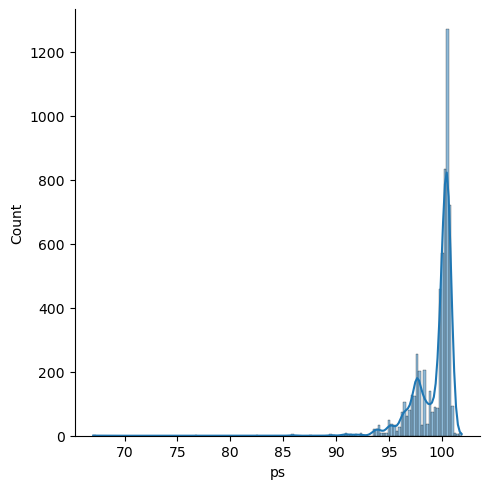

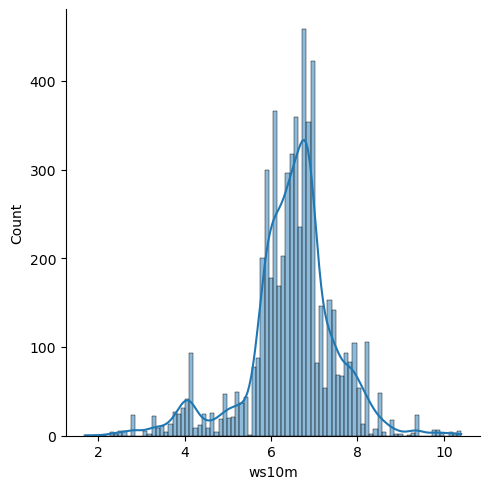

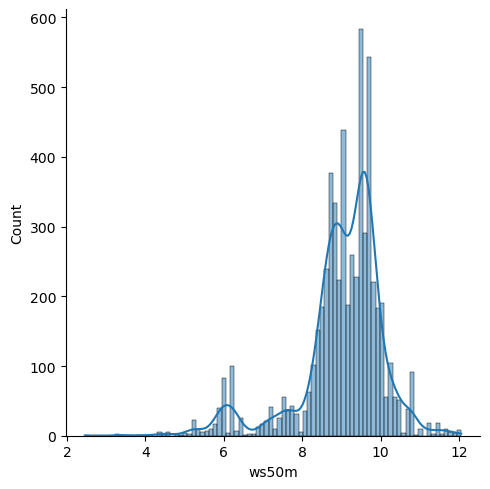

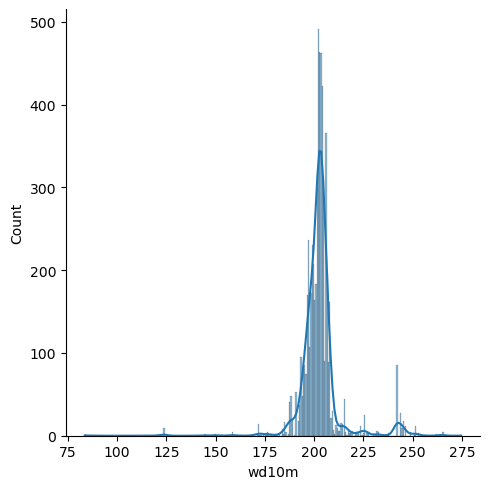

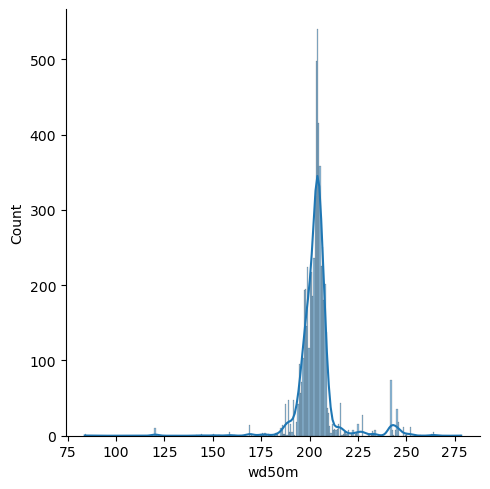

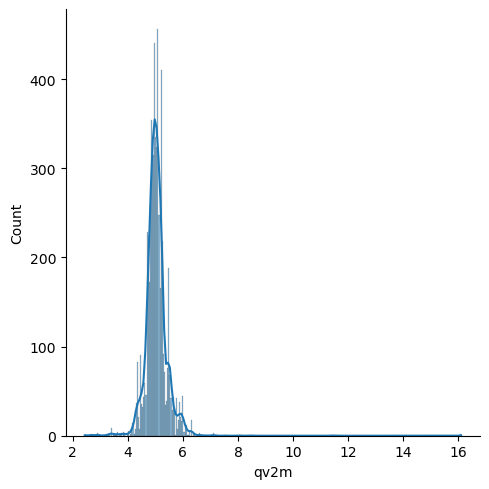

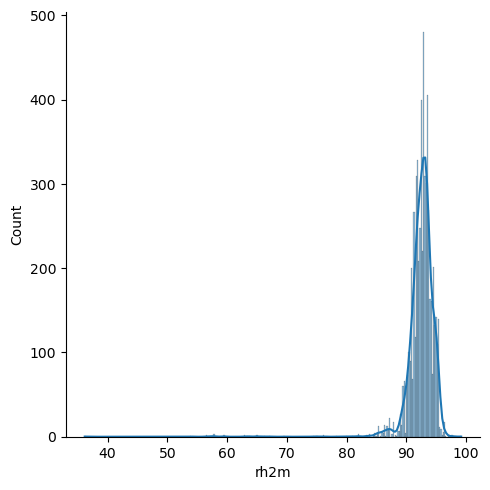

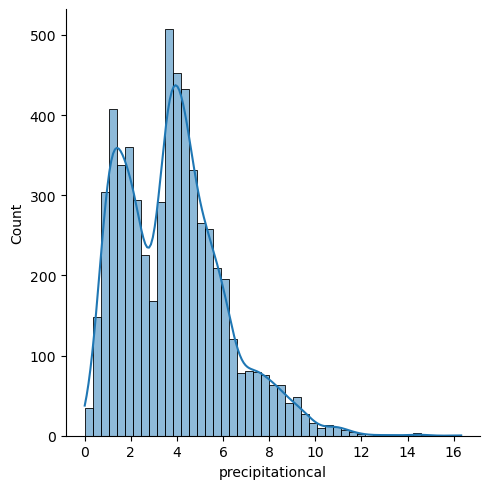

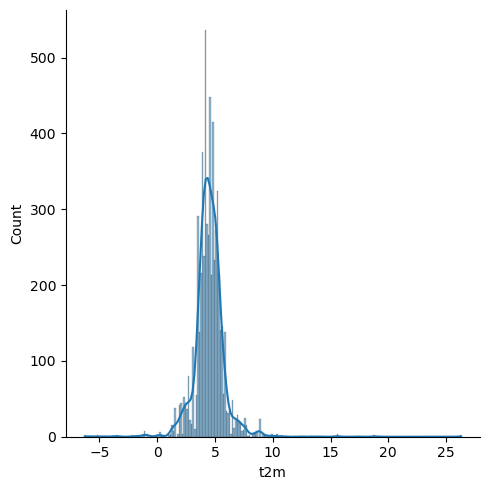

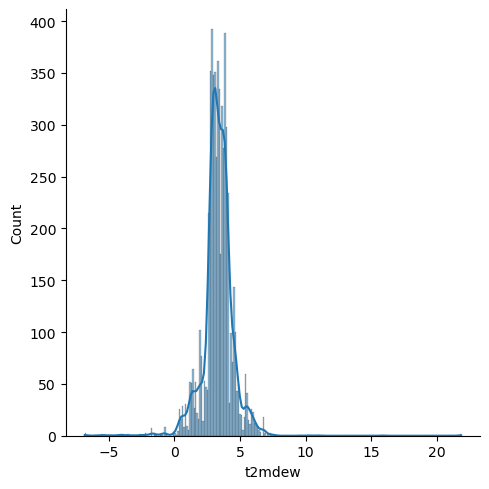

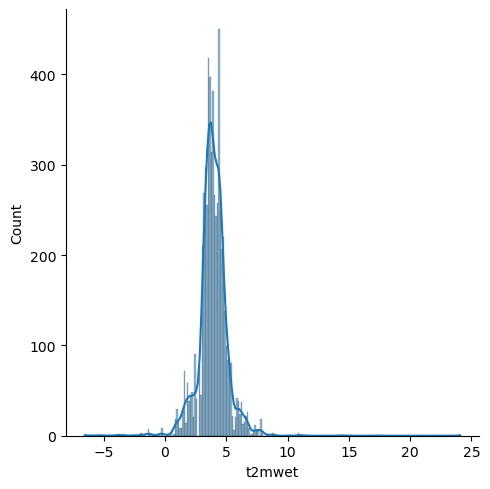

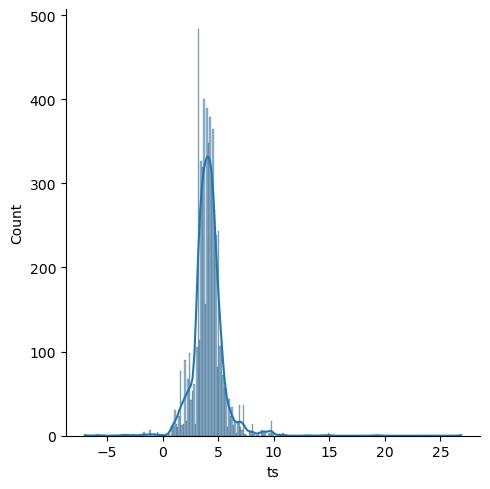

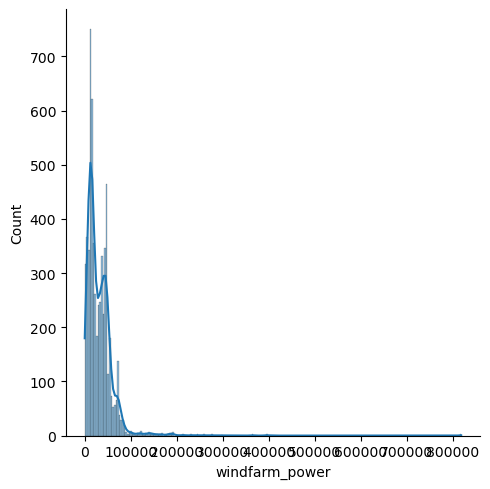

In [447]:
for col in df_wind_dataset.columns[2:]:
    sns.displot(data=df_wind_dataset, x=col, kde=True)

We see a lot of scope of clearing out the outliers from the data features after observing the above graphs. We'll plot the boxplots and remove the obvious outliers.

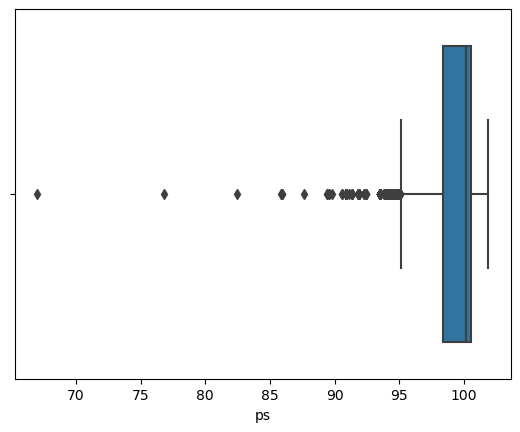

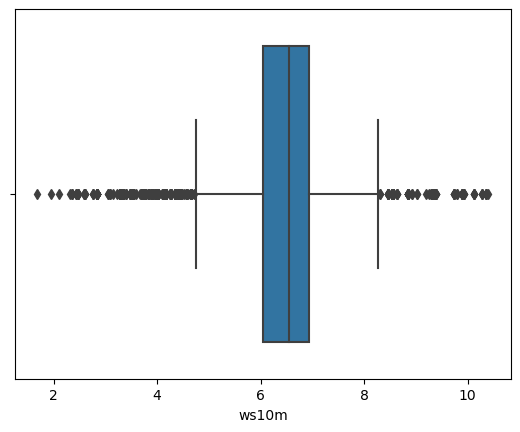

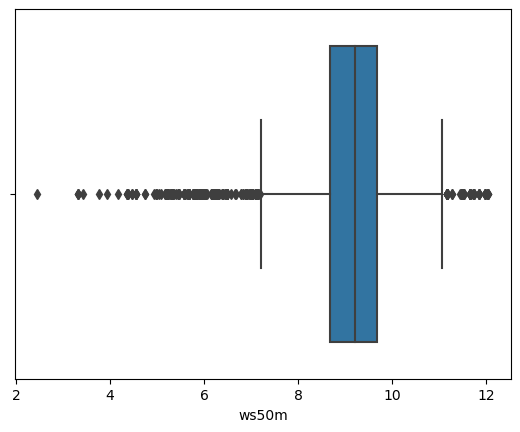

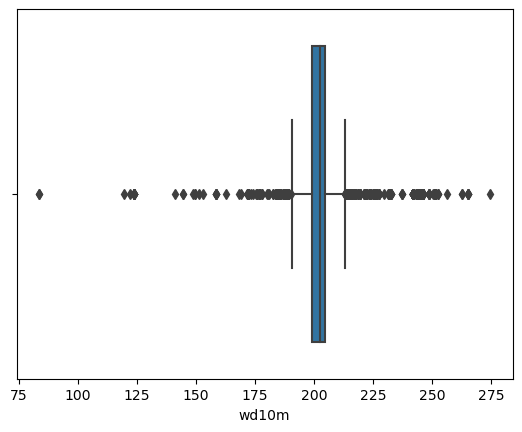

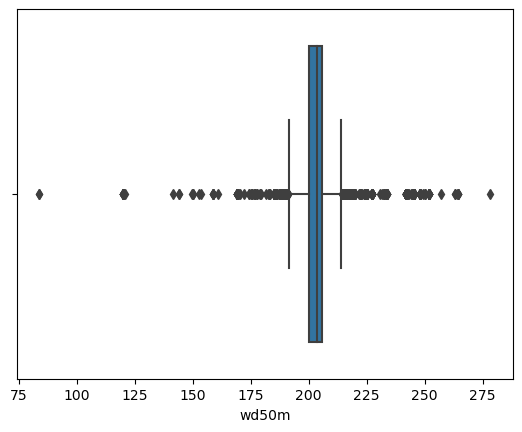

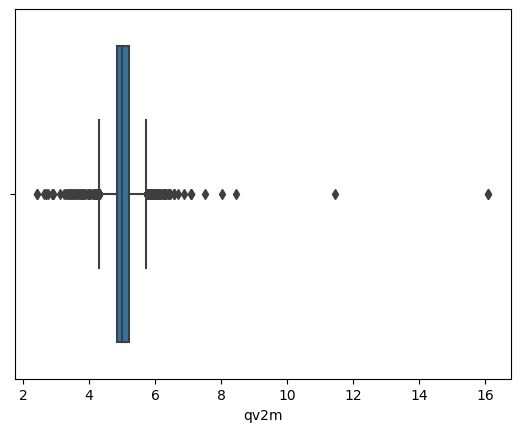

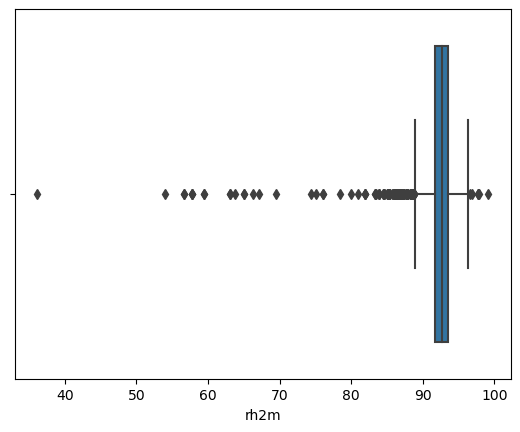

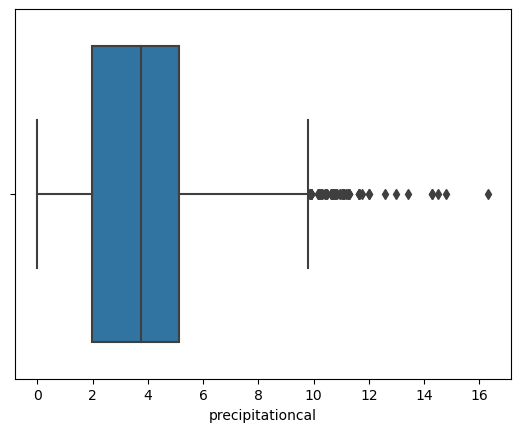

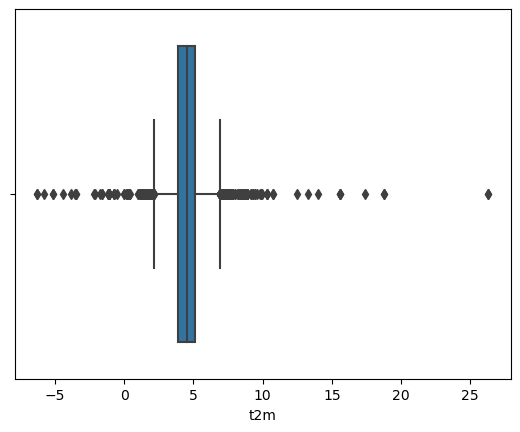

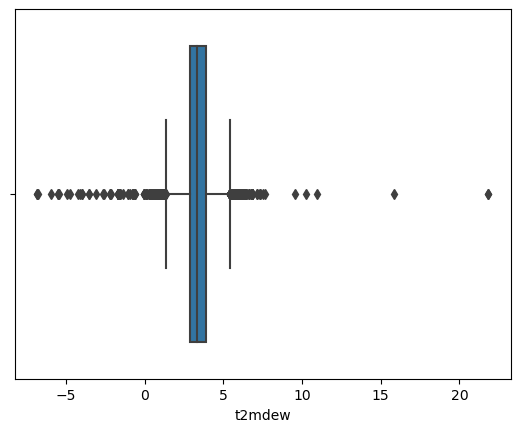

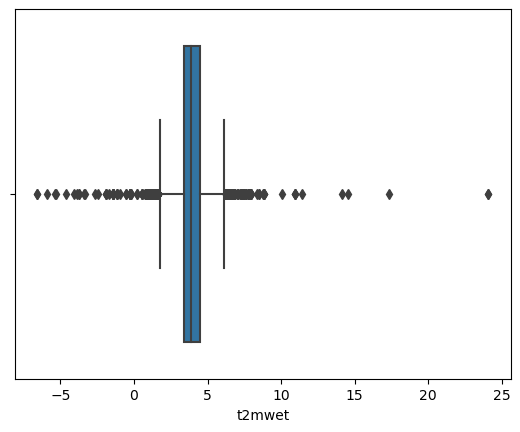

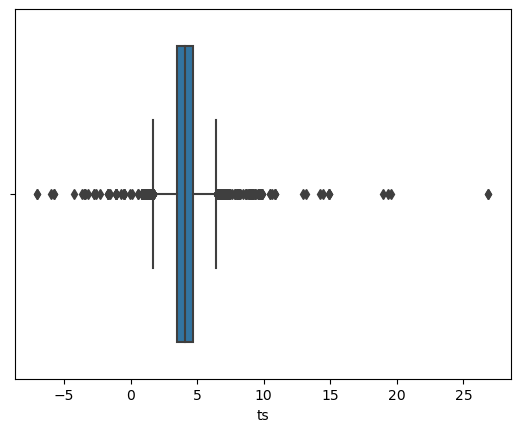

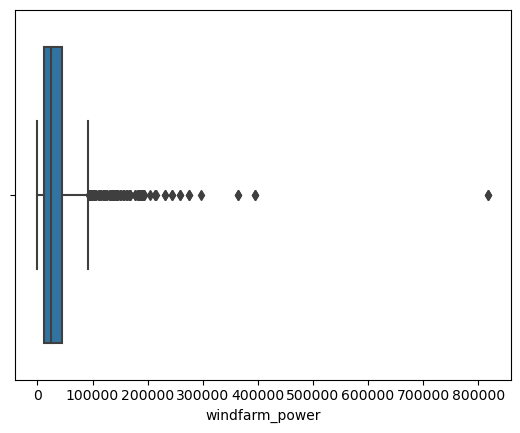

In [448]:
for i, col in enumerate(df_wind_dataset.columns[2:]):
    plt.figure(i)
    sns.boxplot(x=df_wind_dataset[col])

Remove the outliers by including only the values which fall in the distribution and remove otherwise. We'll follow the np.percentile method, only if we observe the outliers are present on both the sides of the normal distribution. Otherwise, we'll just filter the rows based on filter condition of the outlier.

In [449]:
df_wind_dataset.shape

(5972, 15)

In [450]:
df_wind_dataset = df_wind_dataset[df_wind_dataset['ps']>90]
df_wind_dataset = df_wind_dataset[df_wind_dataset['ws50m']>3]
df_wind_dataset = df_wind_dataset[df_wind_dataset['wd10m']>125]
df_wind_dataset = df_wind_dataset[df_wind_dataset['qv2m']<7]
df_wind_dataset = df_wind_dataset[df_wind_dataset['rh2m']>80]
df_wind_dataset = df_wind_dataset[df_wind_dataset['precipitationcal']<13]
df_wind_dataset = df_wind_dataset[df_wind_dataset['t2m']>-2.5]
df_wind_dataset = df_wind_dataset[df_wind_dataset['t2mdew']>-2]
df_wind_dataset = df_wind_dataset[df_wind_dataset['windfarm_power']<300000]

In [451]:
df_wind_dataset.shape

(5910, 15)

We removed appx. 1% of the rows while clearing the outliers. So hopefully it wouldn't affect the performance of the model.

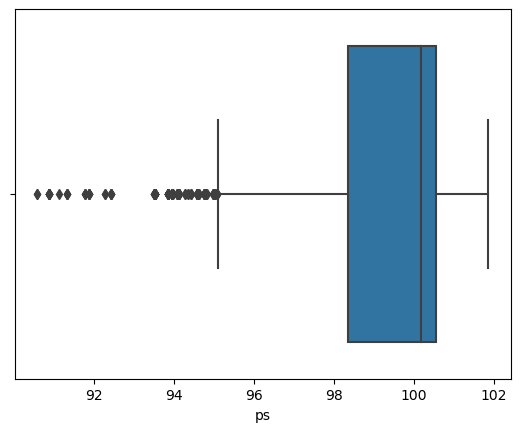

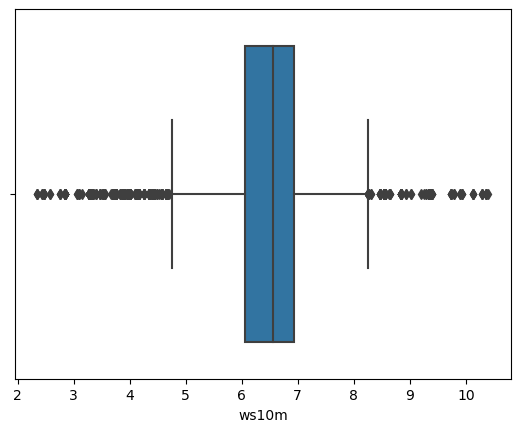

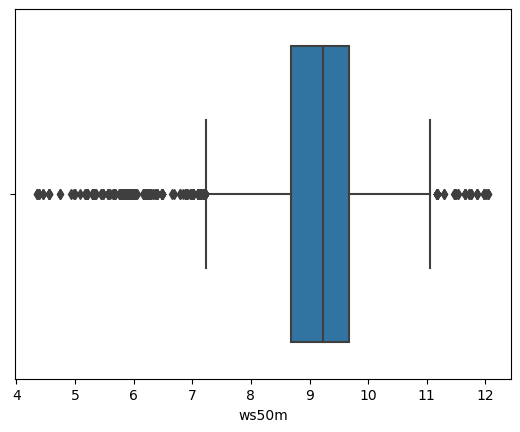

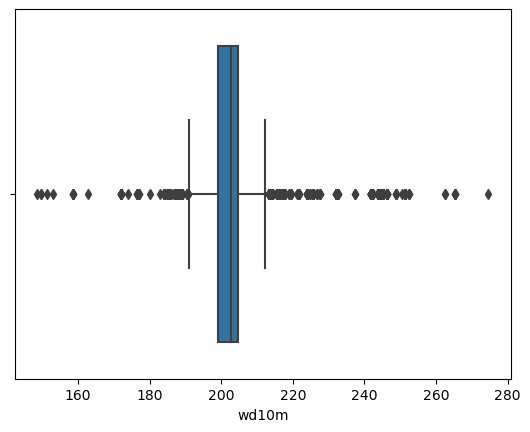

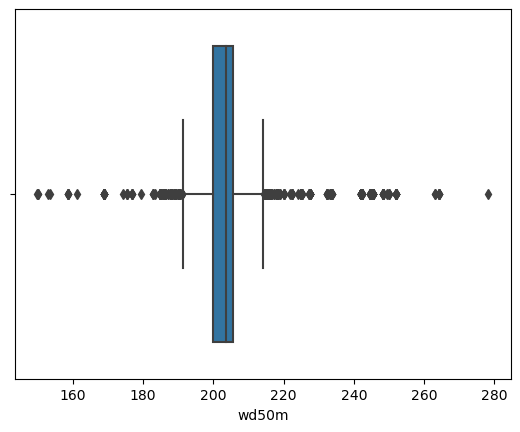

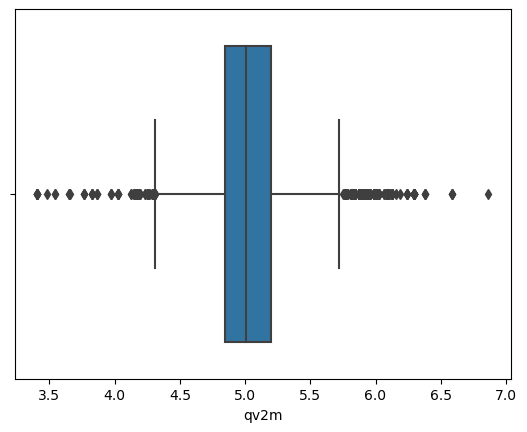

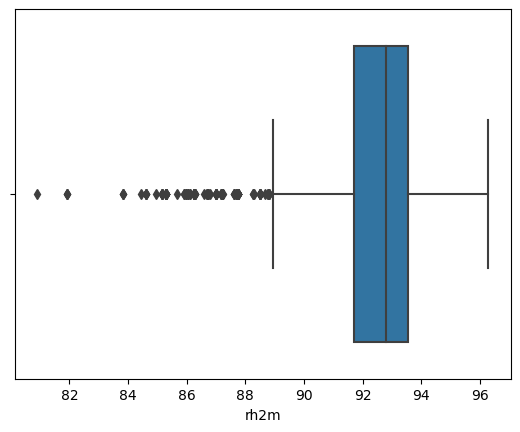

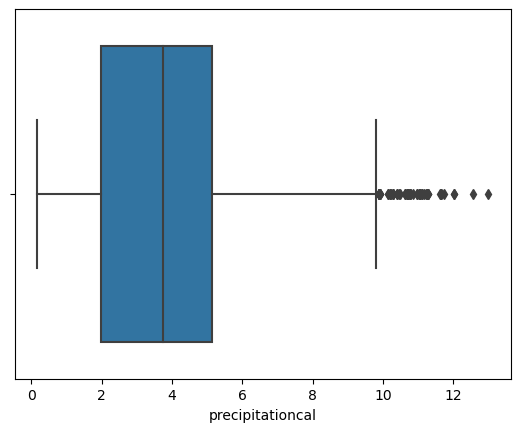

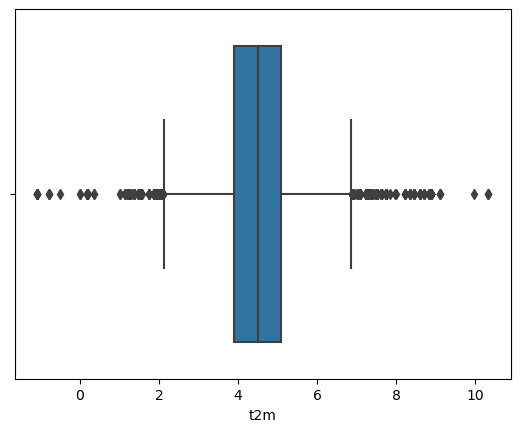

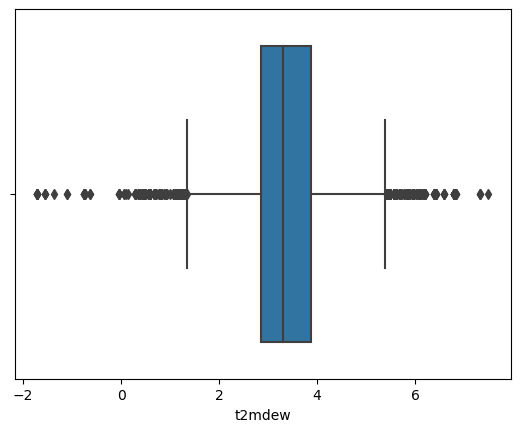

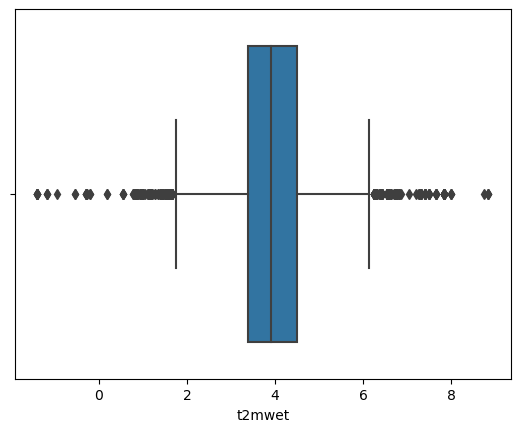

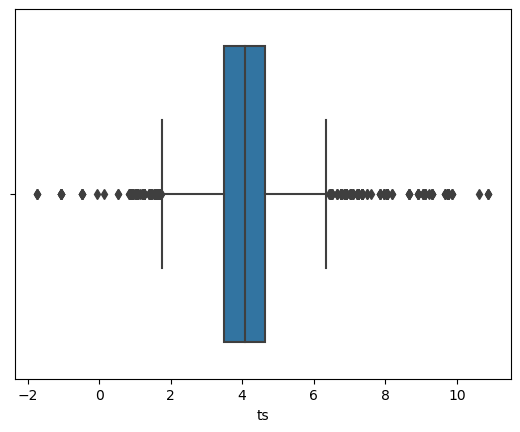

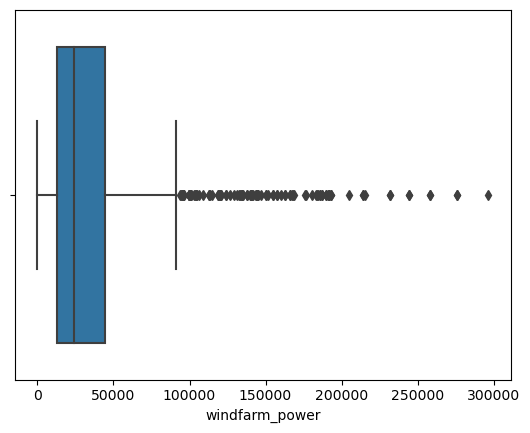

In [452]:
for i, col in enumerate(df_wind_dataset.columns[2:]):
    plt.figure(i)
    sns.boxplot(x=df_wind_dataset[col])

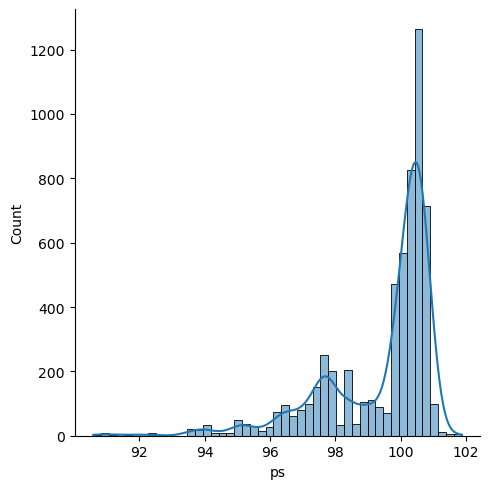

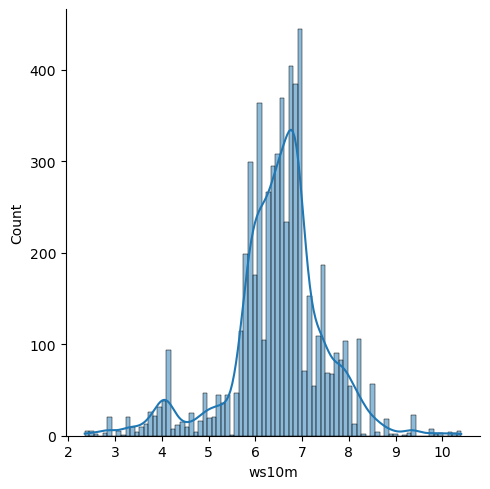

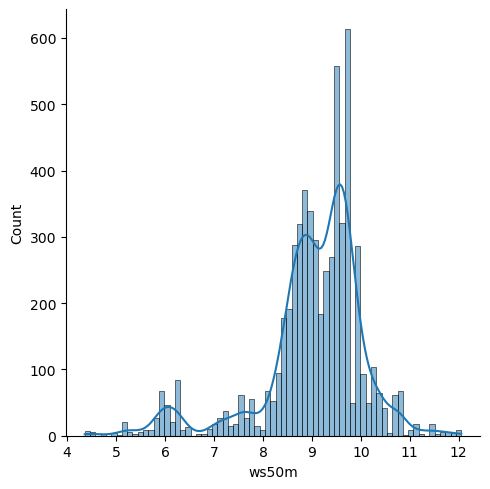

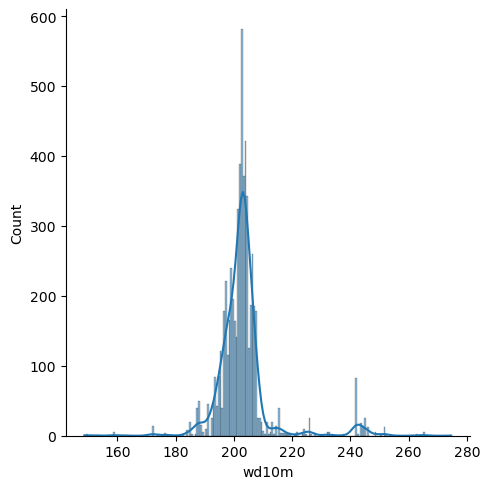

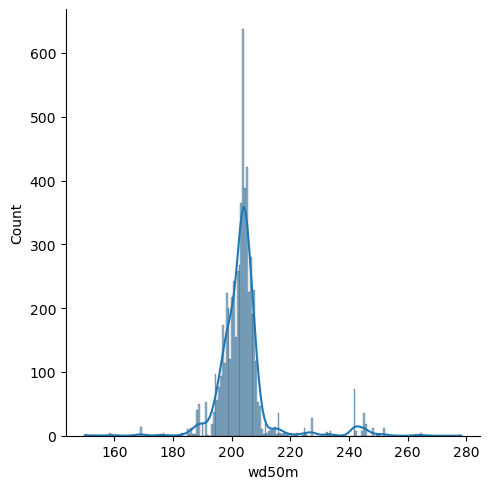

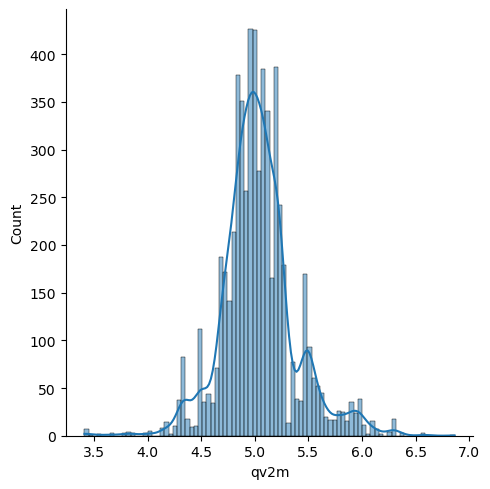

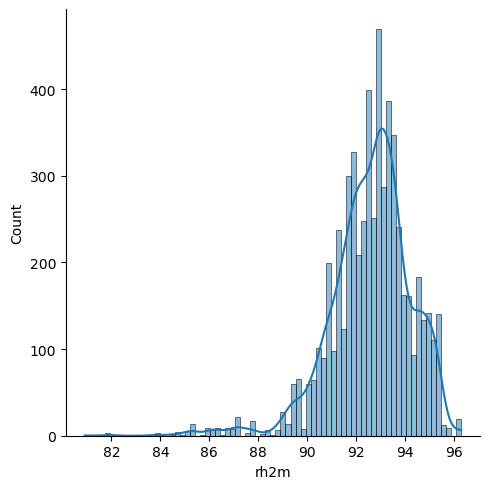

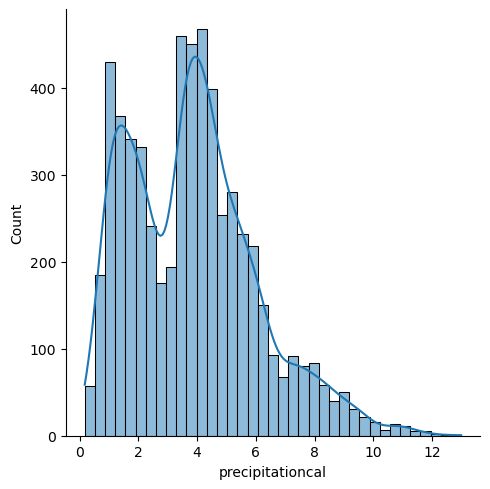

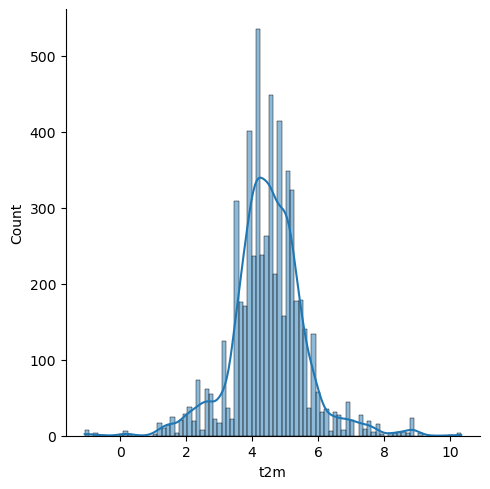

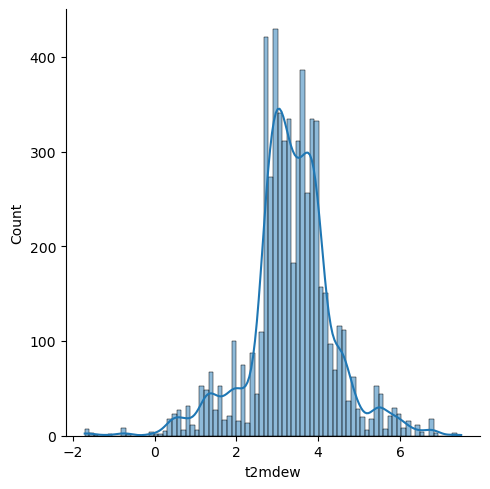

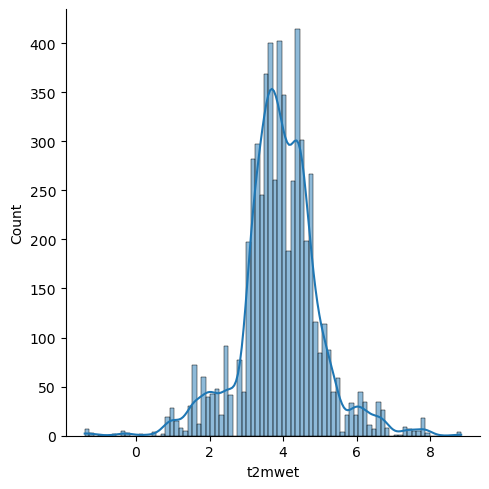

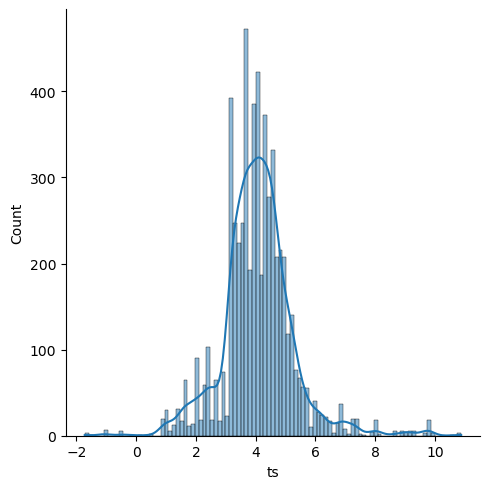

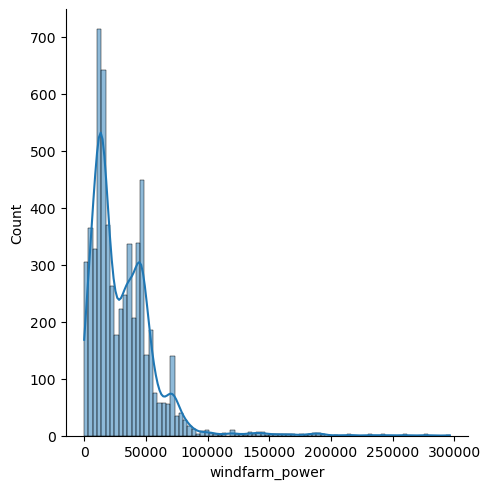

In [453]:
for col in df_wind_dataset.columns[2:]:
    sns.displot(data=df_wind_dataset, x=col, kde=True)

Plot the Regression graph to observe the effect of weather features with the wind power

In [454]:
y= df_wind_dataset['windfarm_power']
# X = df_wind_dataset.drop(['latitude','longitude','windfarm_power'], axis = 1)
X = df_wind_dataset.drop(['windfarm_power'], axis = 1)

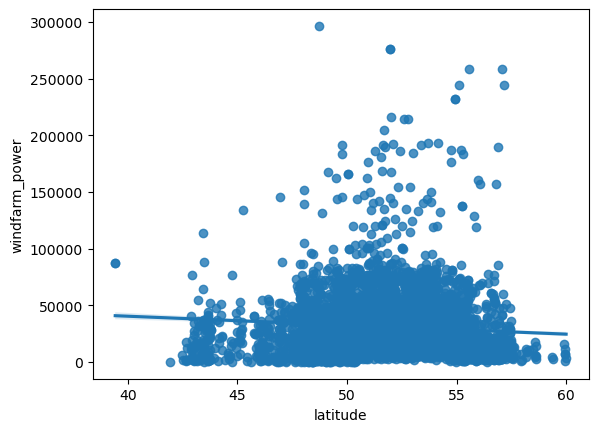

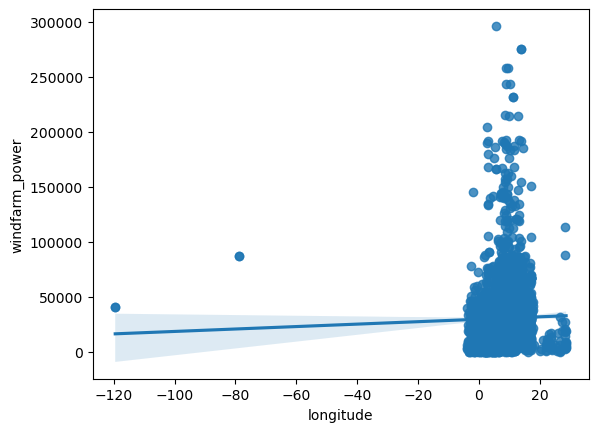

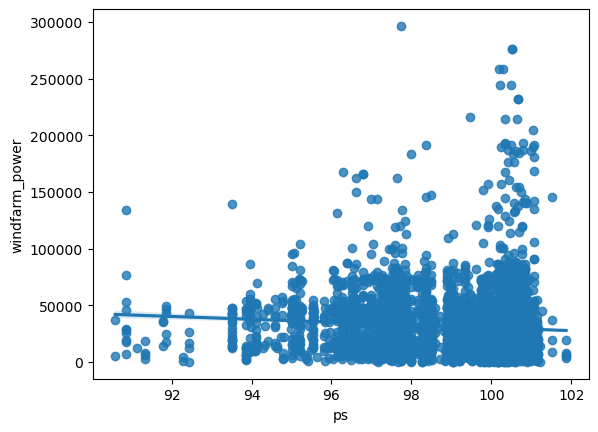

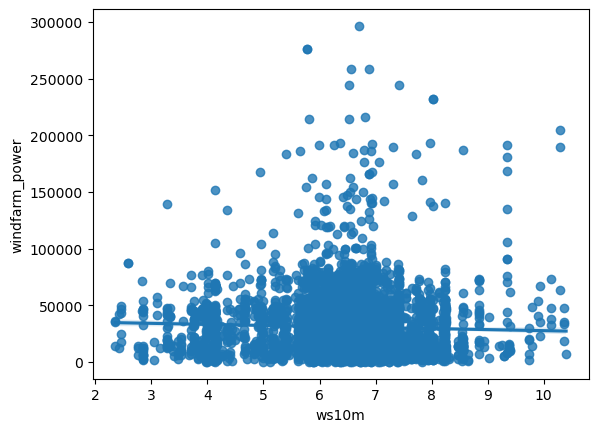

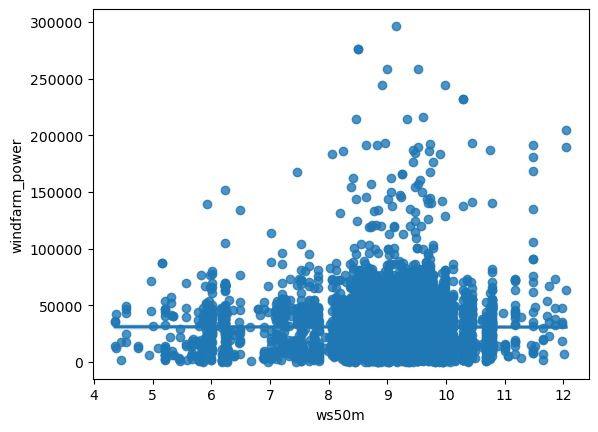

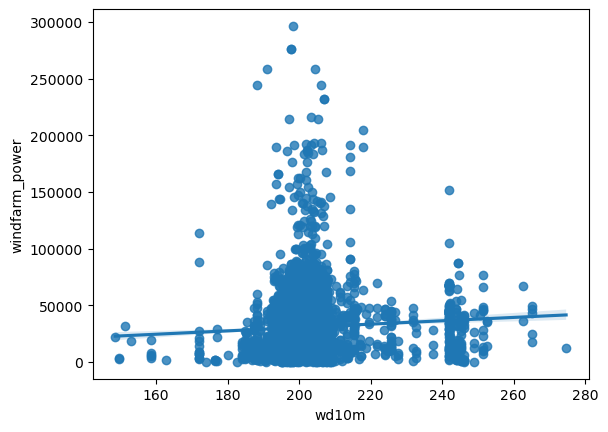

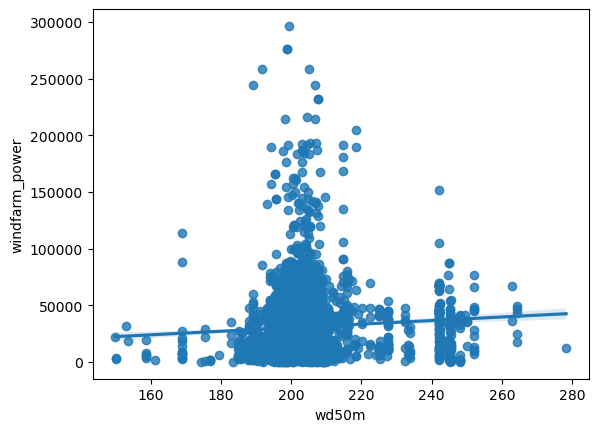

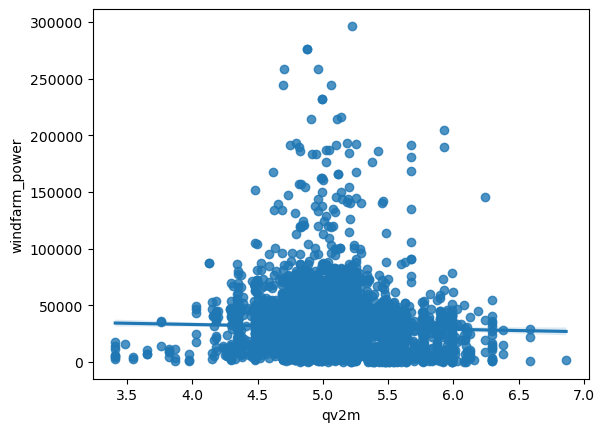

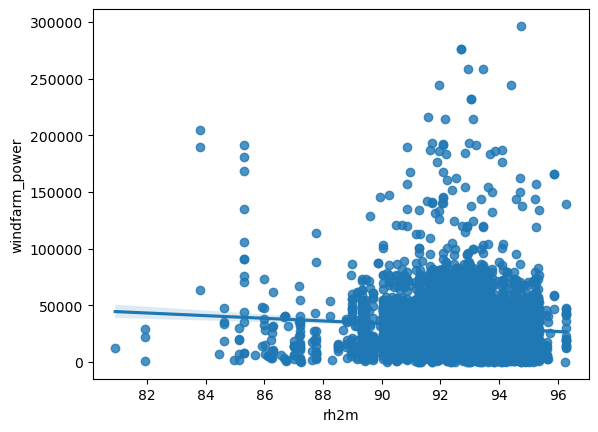

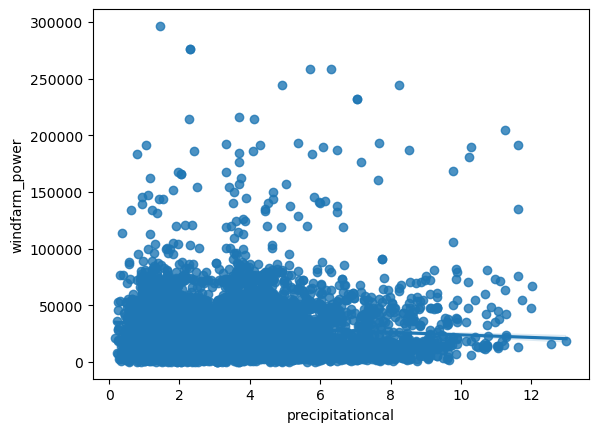

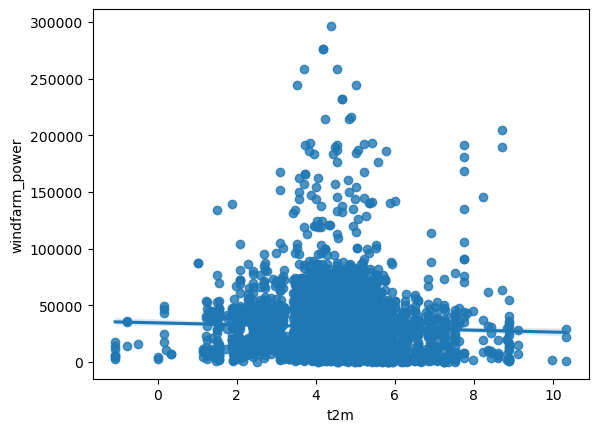

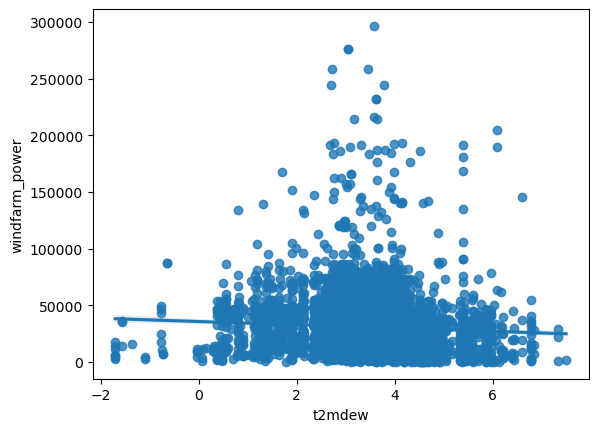

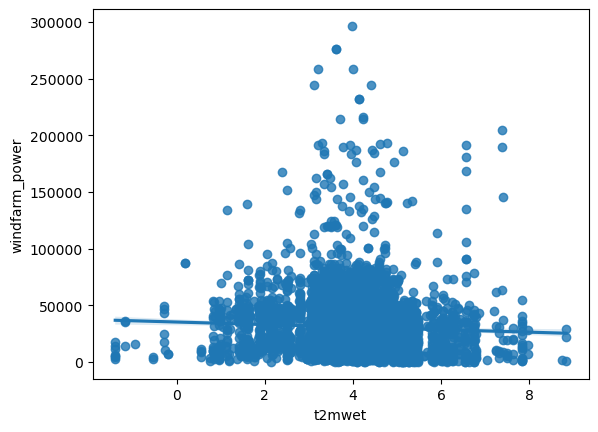

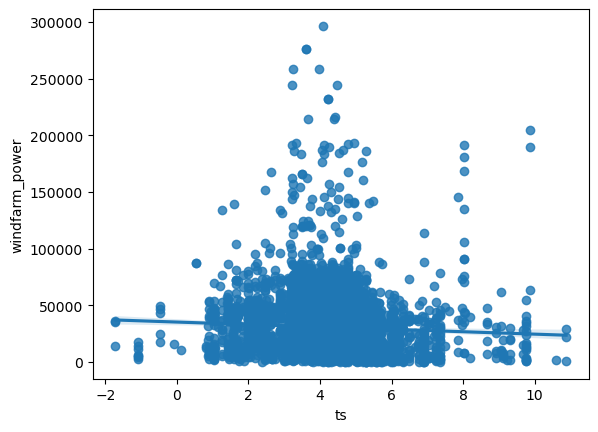

In [455]:
for i, col in enumerate(X.columns):
    plt.figure(i)
    sns.regplot(x=X[col], y=y)

### NOTE:

Even though we're proceeding with the building up a predictive regressor model, we observe in the above plots, there are number of columns negatively or very little correlated with the output variable. Mainly the wind parameters have a positive correlation with the output power. This is due to number of factors as below:

+ The lack of historical power data beyond a month for each wind farm will make it tough for the model to generalize and high chances of overfitting would happen, and very low test accuracy would occur as we'll see below.
+ Due to the limitation of the number of output variables that needed to be included for webAPI call, not all weather parameters could be included, which could significantly improve the performance of the model. 
+ Moreover, as I'll include in the PPT, there are other external parameters (which Jan also mentioned), apart from weather or environmental factors, that affect the output power like proximity of the windfarm with the grid station etc. The model imporvement can be taken as an activity beyond the bootcamp.



## Hypothesis Testing

In [478]:
# Two-sided test:
# Null hypothesis or H0: mean Wind Speed (10m) = mean Wind Speed (50m) 
# Alternative hyp or H1: mean Wind Speed (10m) <> mean Wind Speed (50m)

from scipy.stats import ttest_1samp
stat, pval = ttest_1samp(df_wind_dataset['ws10m'], df_wind_dataset['ws50m'].mean())
print('stat is  ', stat)
print('pvalue for the two-tailed test is ', pval)

# Inference - As the t-statistic value is of postivie nature, the mean of the sample falls on the positive side of 30.0,
# meaning greater than 30, and the p-value is superlow which is tending to 0, meaning that null hypothesis H0 can comfortably
# be rejected to give way to alternate hypothesis being true, which means hourly wage significantly differs from 30$/hr.

stat is   -191.87640852928237
pvalue for the two-tailed test is  0.0


In [ ]:
df_wind_dataset

## Feature Selection

### Traditional Method (Correlation Matrix)

Plot the heatmap for correlation matrix and identify multi-collinearity

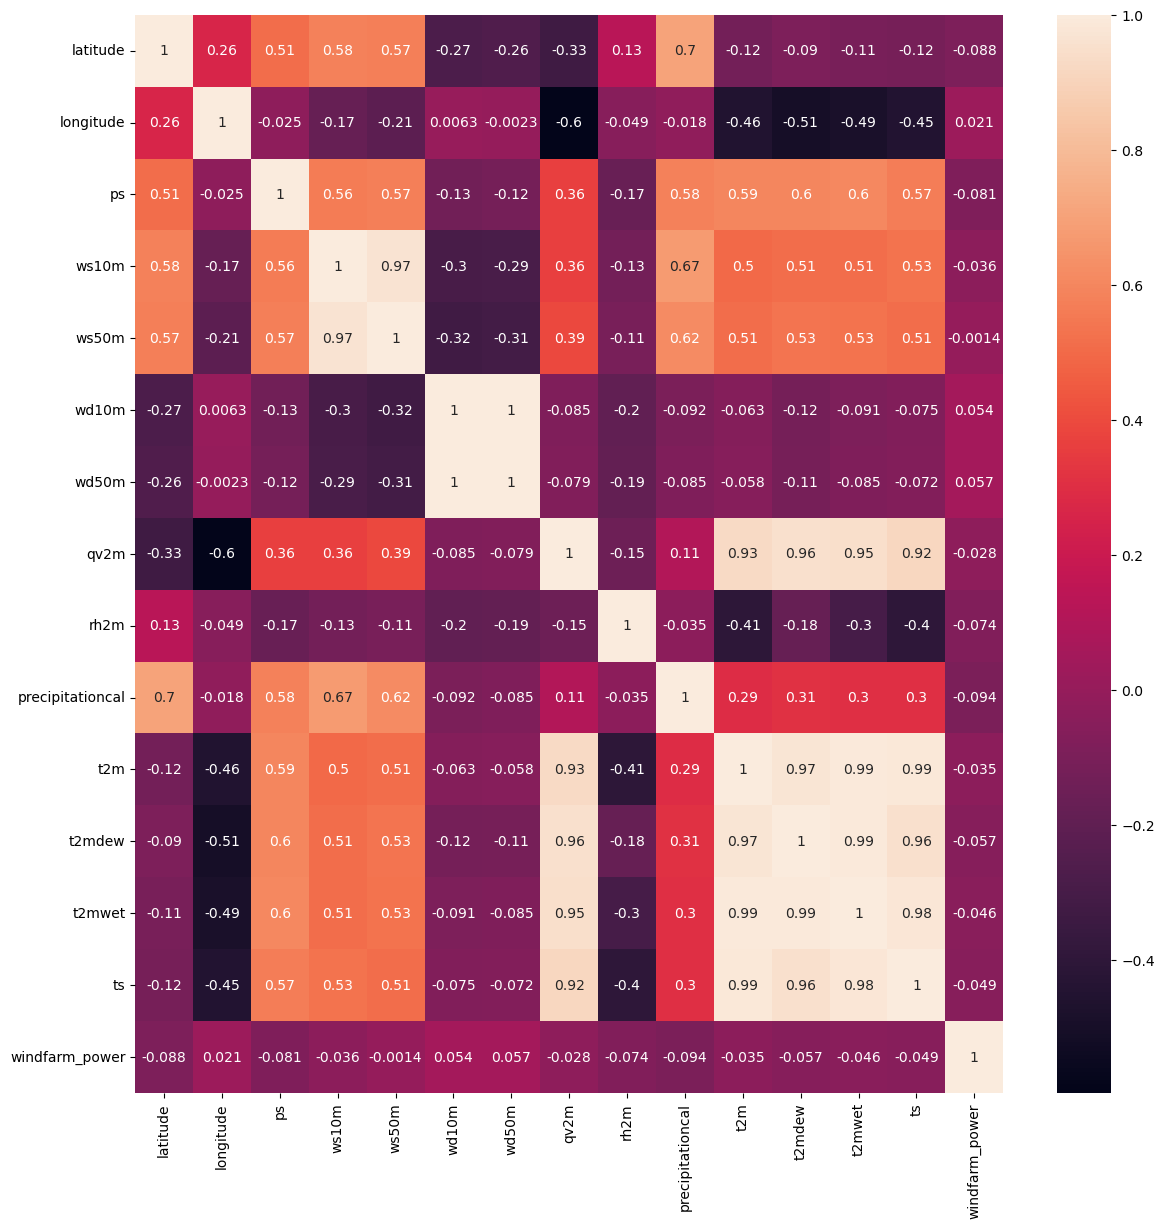

In [456]:
disp_corr_heatmap(X,y)

### The below analysis will be reconsidered if the data is refreshed after new data comes, and correlation matrix gets changed.

NOTE: As you've observed above, we included the inclusion of latitude and longitude to our analysis, as we inferred that the location might have a linear significance with the wind power due to obvious possibility of its effect by the winds and the their direction.

We assume the threshold for removal of the multi collinear columns to be 0.95 and above.

As we observe from the heatmap, there are number of column which are collinear and we need to remove them before building the model.

- ws10m and ws50m are directly collinear (which is obvious) and we select the one having higher correlation with the output and remove the other.

    + removal - ws10m

- Similarly, it goes with the wd10m and wd50m and we choose the better one (higher correlation with the target)

    + removal - wd10m

- Other column removals:

    + t2mwet
    + ts
    
And incase we also look into high correlation of input columns to the target, we are left with only one column: wd50m which we can slice to be taken as the input feature set. (and in that case, we'll bypass the SelectKBest Feature Selection.

In [457]:
# X=X[['wd50m']]

### SelectKBest Feature Selection

NOTE: Use this only incase you don't use the correlation matrix.

Although traditional method is good for analysis, we'll proceed with SelectKBest feature selection method for identifying the top features for building the model.

As our output column is continuous,m we'll use the f_regression function for helping in selecting the features.

In [458]:
select = SelectKBest(score_func=f_regression, k=10)
z = select.fit_transform(X, y)

filter = select.get_support()
features = array(X.columns)

X = X[features[filter]]

X.head()

,latitude,ps,ws10m,wd10m,wd50m,rh2m,precipitationcal,t2mdew,t2mwet,ts
6,45.77950,97.638710,3.327742,195.863548,196.966774,86.698710,1.923871,0.591935,1.664516,1.452258
7,45.77950,97.638710,3.327742,195.863548,196.966774,86.698710,1.923871,0.591935,1.664516,1.452258
14,39.42625,96.393548,2.577419,244.419355,245.084839,89.878387,3.036452,-0.642581,0.188710,0.520645
15,39.42625,96.393548,2.577419,244.419355,245.084839,89.878387,3.036452,-0.642581,0.188710,0.520645
25,47.83225,99.782581,4.129355,241.967742,242.109032,92.407097,1.128065,1.908710,2.495806,2.465161


## Predictive Modelling

In [459]:
X_train, X_test, y_train, y_test, transformer = transform(X,y,ignore_cat=True,random_state=424,verbose=True)

X_train_num_scaled:


,latitude,ps,ws10m,wd10m,wd50m,rh2m,precipitationcal,t2mdew,t2mwet,ts
0,0.658618,0.886486,0.480799,0.447697,0.438357,0.692253,0.370328,0.555482,0.533539,0.471035
1,0.196902,0.874814,0.350116,0.186325,0.148165,0.444717,0.014472,0.715882,0.712763,0.685217
2,0.511588,0.848781,0.544897,0.371366,0.364478,0.813913,0.192192,0.663116,0.615945,0.535134
3,0.653451,0.864830,0.519482,0.449235,0.443671,0.730632,0.323295,0.579482,0.550443,0.484859
4,0.693147,0.909572,0.626674,0.440602,0.430556,0.785705,0.404503,0.626222,0.585480,0.507001


X_train_num_scaled:


,latitude,ps,ws10m,wd10m,wd50m,rh2m,precipitationcal,t2mdew,t2mwet,ts
0,0.565396,0.636629,0.468171,0.421784,0.408091,0.673755,0.091437,0.416524,0.410483,0.364905
1,0.642912,0.873956,0.567145,0.424328,0.415470,0.718972,0.287038,0.609649,0.579142,0.512044
2,0.753869,0.893209,0.693939,0.454288,0.441639,0.789732,0.517543,0.561613,0.526223,0.453705
3,0.572316,0.913634,0.568789,0.417225,0.408232,0.703620,0.463404,0.682141,0.646378,0.563830
4,0.773913,0.845291,0.513028,0.424635,0.415299,0.902877,0.474050,0.549490,0.502318,0.431844


X_train:


,latitude,ps,ws10m,wd10m,wd50m,rh2m,precipitationcal,t2mdew,t2mwet,ts
0,0.658618,0.886486,0.480799,0.447697,0.438357,0.692253,0.370328,0.555482,0.533539,0.471035
1,0.196902,0.874814,0.350116,0.186325,0.148165,0.444717,0.014472,0.715882,0.712763,0.685217
2,0.511588,0.848781,0.544897,0.371366,0.364478,0.813913,0.192192,0.663116,0.615945,0.535134
3,0.653451,0.864830,0.519482,0.449235,0.443671,0.730632,0.323295,0.579482,0.550443,0.484859
4,0.693147,0.909572,0.626674,0.440602,0.430556,0.785705,0.404503,0.626222,0.585480,0.507001


X_test:


,latitude,ps,ws10m,wd10m,wd50m,rh2m,precipitationcal,t2mdew,t2mwet,ts
0,0.565396,0.636629,0.468171,0.421784,0.408091,0.673755,0.091437,0.416524,0.410483,0.364905
1,0.642912,0.873956,0.567145,0.424328,0.415470,0.718972,0.287038,0.609649,0.579142,0.512044
2,0.753869,0.893209,0.693939,0.454288,0.441639,0.789732,0.517543,0.561613,0.526223,0.453705
3,0.572316,0.913634,0.568789,0.417225,0.408232,0.703620,0.463404,0.682141,0.646378,0.563830
4,0.773913,0.845291,0.513028,0.424635,0.415299,0.902877,0.474050,0.549490,0.502318,0.431844


### Model Comparison

NOTE: As shared earlier in the presentation, the results for model performance doesn't look good below, essentially due to 2 major things:

+ The lack of historical data for each wind farm makes it difficult for the model to generalize well. It seems to get overfitted by giving good training score and very poor test score.

+ The exhaustive weather features are lacking. Most of the columns retreived from nasa data power portal were multi collinear and therefore has to essentially remove them iteratively for model building leading to low number of features, and thus low accuracy.

In [460]:
model_dict={
    'Regression Tree': DecisionTreeRegressor(),
    'Linear Regression': LinearRegression(),
    'Random Forest':RandomForestRegressor()
}

In [461]:
model_pipeline(X_train, X_test, y_train, y_test,model_dict)

Cross Validation Scores:
Regression Tree  :  -0.58
Linear Regression  :  0.04
Random Forest  :  -0.04
Accuracy Scores:
Regression Tree  :  -0.59
Linear Regression  :  0.03
Random Forest  :  -0.1


Part of the pipeline

In [462]:
rfr = RandomForestRegressor(
                            n_estimators=100,
                            max_depth=50,
                            random_state=2337,
                            n_jobs=-1
                            )
rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=50, n_jobs=-1, random_state=2337)

In [ ]:
predictions = rfr.predict(X_test)

Not part of the pipeline

In [463]:
disp_score_reg(rfr,X_train, X_test, y_train, y_test)

Training Score:
R2 Score: 0.81
Mean Squared Error: 129286629.07
Mean aboslute Error: 7322.87
Root Mean Squared Error: 11370.43

Test Score:
R2 Score: -0.1
Mean Squared Error: 756207713.56
Mean aboslute Error: 18168.45
Root Mean Squared Error: 27499.23


Part of the pipeline

In [464]:
lm =LinearRegression().fit(X_train, y_train)

In [ ]:
predictions = lm.predict(X_test)

Not part of the pipeline

In [465]:
disp_score_reg(lm,X_train, X_test, y_train, y_test)

Training Score:
R2 Score: 0.05
Mean Squared Error: 661758776.74
Mean aboslute Error: 17871.59
Root Mean Squared Error: 25724.67

Test Score:
R2 Score: 0.03
Mean Squared Error: 668001903.13
Mean aboslute Error: 17957.09
Root Mean Squared Error: 25845.73
